In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("http://math.ucla.edu/~dmenezes/SouvenirSales.csv", index_col=0, decimal=',')
df.index = pd.to_datetime(df.index, format="%b.%y")

In [4]:
df

,Sales
Date,
1995-01-01,1664.81
1995-02-01,2397.53
1995-03-01,2840.71
1995-04-01,3547.29
1995-05-01,3752.96
...,...
2001-08-01,28586.52
2001-09-01,30505.41
2001-10-01,30821.33


<Axes: xlabel='Date'>

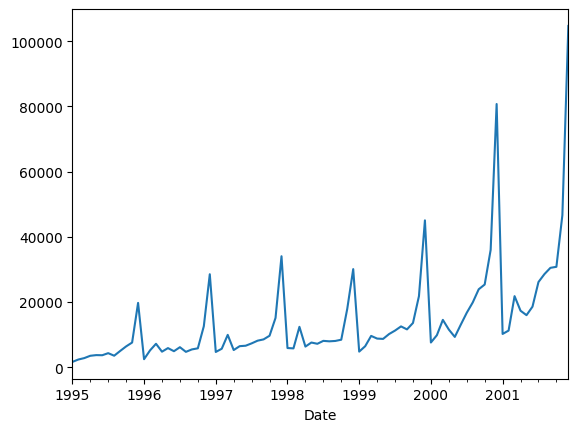

In [5]:
df["Sales"].plot()

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
adfuller(df["Sales"])


(2.316544104902997,
 0.9989654538596132,
 12,
 71,
 {'1%': -3.526004646825607,
  '5%': -2.9032002348069774,
  '10%': -2.5889948363419957},
 1392.4239579001335)

We get that the Augmented Dickey Fuller test fails to reject the null hypothesis.


```
# This is formatted as code
```



In [9]:
diff = df["Sales"].diff(periods=12).dropna()

In [10]:
diff

Date
1996-01-01      835.00
1996-02-01     2800.71
1996-03-01     4384.43
1996-04-01     1258.74
1996-05-01     2147.92
                ...   
2001-08-01     8697.91
2001-09-01     6572.03
2001-10-01     5429.98
2001-11-01    10609.58
2001-12-01    23938.99
Name: Sales, Length: 72, dtype: float64

In [18]:
diff2 = df.diff().dropna().diff(periods=12).dropna()

In [19]:
adfuller(diff2)

(-5.3915138610737205,
 3.5290254665330157e-06,
 10,
 60,
 {'1%': -3.5443688564814813,
  '5%': -2.9110731481481484,
  '10%': -2.5931902777777776},
 1163.2172244717203)

If we subtract last year's value we we still don't get a stationary series.
If we then take differences we do get a stationary series.

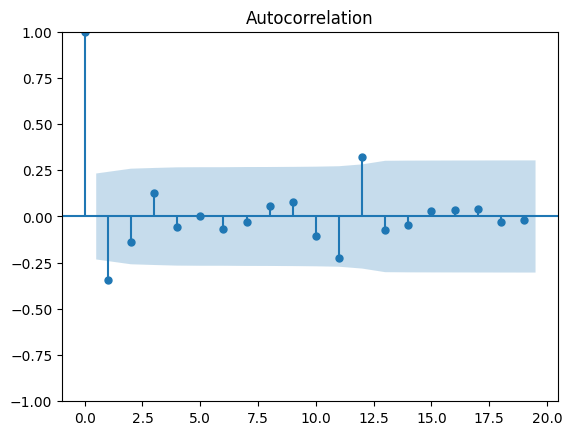

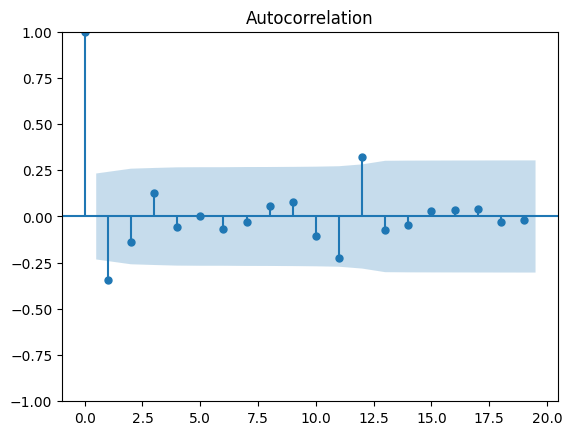

In [20]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(diff2)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


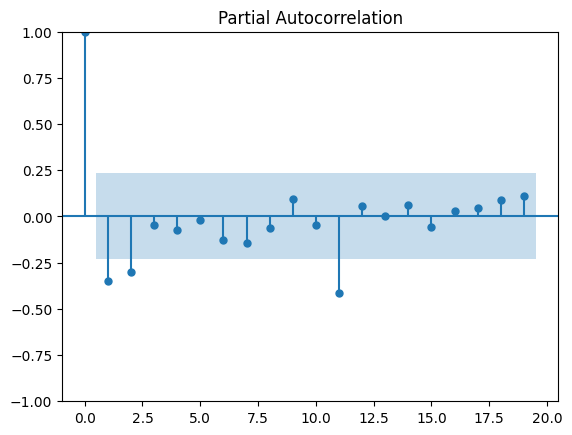

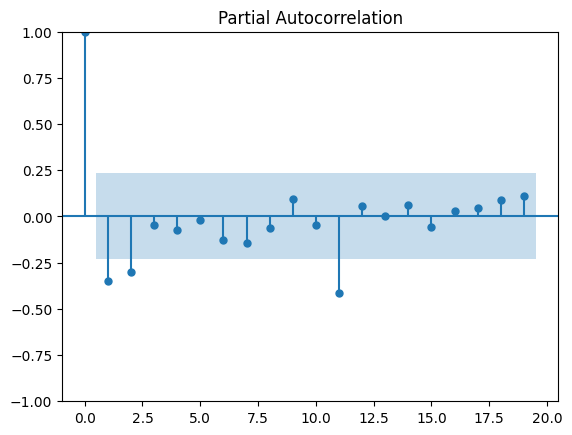

In [21]:
sm.graphics.tsa.plot_pacf(diff2)

It looks like they are becoming nonsignificant after the second lag.
Everything is insignificant after the 12th lag.

In [22]:
train = df[:-12]

In [23]:
test=df[-12:]

In [24]:
test

,Sales
Date,
2001-01-01,10243.24
2001-02-01,11266.88
2001-03-01,21826.84
2001-04-01,17357.33
2001-05-01,15997.79
2001-06-01,18601.53
2001-07-01,26155.15
2001-08-01,28586.52
2001-09-01,30505.41


In [28]:
rolling_mean = df.rolling(window = 12).mean()
rolling_mean_diff = rolling_mean - rolling_mean.shift()

In [33]:
import numpy as np
mean = np.mean(train)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


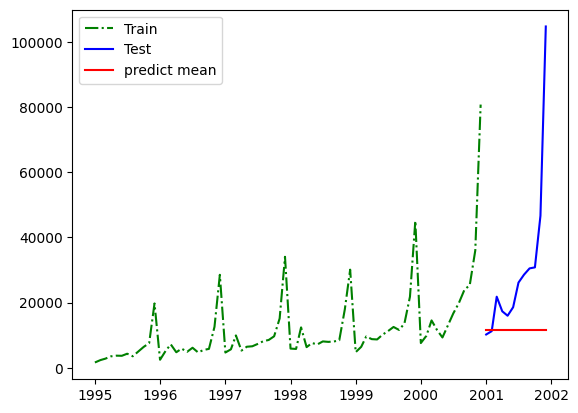

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(train, 'g-.', label='Train')
ax.plot(test, 'b-', label='Test')
ax.plot(test.index, np.array([mean]*12), 'r-', label="predict mean")
plt.legend()

In [42]:
pred_mean = np.array([mean]*12)

In [48]:
np.mean((test.values - pred_mean)**2)

941182645.8858002

In [52]:
ult = 80721.71 # last known value

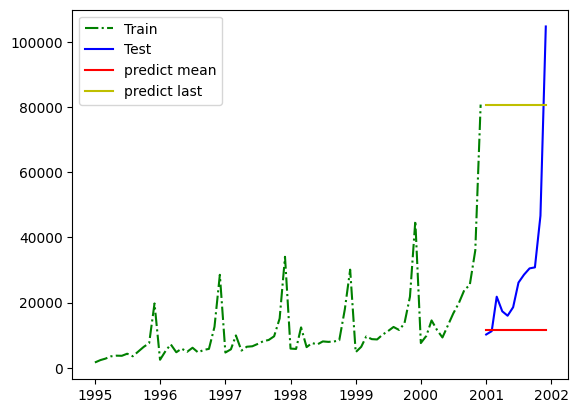

In [53]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(train, 'g-.', label='Train')
ax.plot(test, 'b-', label='Test')
ax.plot(test.index, np.array([mean]*12), 'r-', label="predict mean")
ax.plot(test.index, np.array([ult]*12), 'y-', label="predict last")
plt.legend()

In [55]:
pred_last = np.array([ult]*12)

In [56]:
np.mean((test.values - pred_last)**2)

3147106218.126917

In [57]:
len(train)

72

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
pred_AR = []
for i in range(72, 84, 2):
  model = SARIMAX(df[:i], order=(2,0,0), seasonal_order=(1, 0, 0, 12))
  res = model.fit(disp=False)
  predictions = res.get_prediction(0, i + 2 - 1)
  pred = predictions.predicted_mean[-2:]
  pred_AR.extend(pred)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood

In [62]:
pred_AR

[37188.53881034426,
 39703.03618789202,
 15282.177834318452,
 12062.194310290062,
 13594.315549594045,
 15988.351637484364,
 20345.106556490504,
 22326.41548268668,
 29762.57304754405,
 29768.728727213747,
 39238.632842193845,
 80444.53178452594]

In [74]:
np.array(pred_AR)

array([37188.53881034, 39703.03618789, 15282.17783432, 12062.19431029,
       13594.31554959, 15988.35163748, 20345.10655649, 22326.41548269,
       29762.57304754, 29768.72872721, 39238.63284219, 80444.53178453])

In [75]:
np.transpose(np.array(test.values)) - np.array(pred_AR)

array([[-26945.29881034, -28436.15618789,   6544.66216568,
          5295.13568971,   2403.47445041,   2613.17836252,
          5810.04344351,   6260.10451731,    742.83695246,
          1052.60127279,   7395.74715781,  24216.16821547]])

In [76]:
np.mean((np.transpose(np.array(test.values)) - np.array(pred_AR))**2)

194488810.89727005

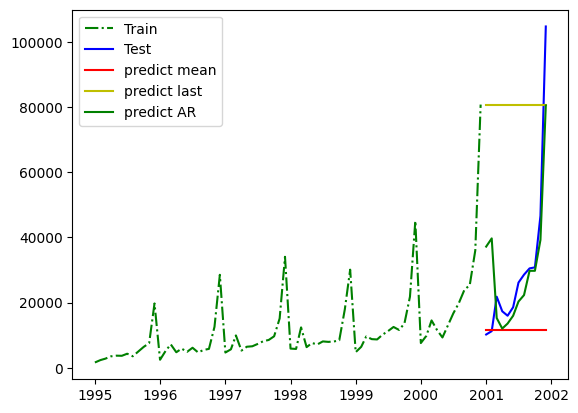

In [77]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(train, 'g-.', label='Train')
ax.plot(test, 'b-', label='Test')
ax.plot(test.index, np.array([mean]*12), 'r-', label="predict mean")
ax.plot(test.index, np.array([ult]*12), 'y-', label="predict last")
ax.plot(test.index, pred_AR, 'g-', label="predict AR")
plt.legend()

In [78]:
pred_AR

[37188.53881034426,
 39703.03618789202,
 15282.177834318452,
 12062.194310290062,
 13594.315549594045,
 15988.351637484364,
 20345.106556490504,
 22326.41548268668,
 29762.57304754405,
 29768.728727213747,
 39238.632842193845,
 80444.53178452594]

In [79]:
test

,Sales
Date,
2001-01-01,10243.24
2001-02-01,11266.88
2001-03-01,21826.84
2001-04-01,17357.33
2001-05-01,15997.79
2001-06-01,18601.53
2001-07-01,26155.15
2001-08-01,28586.52
2001-09-01,30505.41


In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
pred_AR3 = []
for i in range(72, 96, 2):
  model = SARIMAX(df[:i], order=(2,0,0), seasonal_order=(1, 0, 0, 12))
  res = model.fit(disp=False)
  predictions = res.get_prediction(0, i + 2 - 1)
  pred = predictions.predicted_mean[-2:]
  pred_AR3.extend(pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood

In [81]:
pred_AR3

[37188.53881034426,
 39703.03618789202,
 15282.177834318452,
 12062.194310290062,
 13594.315549594045,
 15988.351637484364,
 20345.106556490504,
 22326.41548268668,
 29762.57304754405,
 29768.728727213747,
 39238.632842193845,
 80444.53178452594,
 27703.508130190443,
 27222.92143333624,
 34144.680529208315,
 27809.84741968102,
 24617.76684353531,
 25572.060994489744,
 31490.95987418296,
 32736.979808424043,
 33670.03770986365,
 33221.43008177536,
 47693.3449094513,
 102574.16497590637]

In [82]:
pred_AR

[37188.53881034426,
 39703.03618789202,
 15282.177834318452,
 12062.194310290062,
 13594.315549594045,
 15988.351637484364,
 20345.106556490504,
 22326.41548268668,
 29762.57304754405,
 29768.728727213747,
 39238.632842193845,
 80444.53178452594]

The prediction for January 2002 is 27703.50

